In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Using TensorFlow backend.


/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period_inverse/gru_064_x1_2m03_drop25
[[ 0.59393215  0.94153953  0.05650987 -0.83732233]
 [ 0.74367043  0.4804794   5.73567547 -0.24139383]
 [ 0.64248704  1.24749459  2.78727471 -0.48039218]]
0.000375795815433
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period_inverse/gru_064_x2_2m03_drop25
[[ 0.59393215  0.94153953  0.05650987 -0.83732233]
 [ 0.74367043  0.4804794   5.73567547 -0.24139383]
 [ 0.64248704  1.24749459  2.78727471 -0.48039218]]
0.000539913111387
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period_inverse/gru_064_x3_2m03_drop25
[[ 0.59393215  0.94153953  0.05650987 -0.83732233]
 [ 0.74367043  0.4804794   5.73567547 -0.24139383]
 [ 0.64248704  1.24749459  2.78727471 -0.48039218]]
0.00107977080539


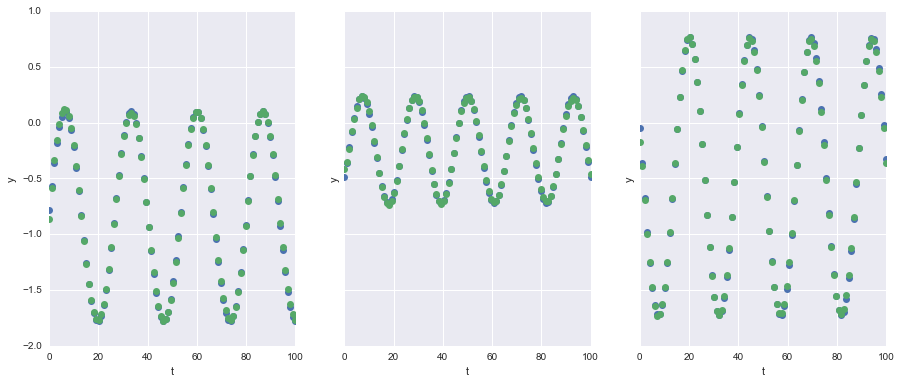

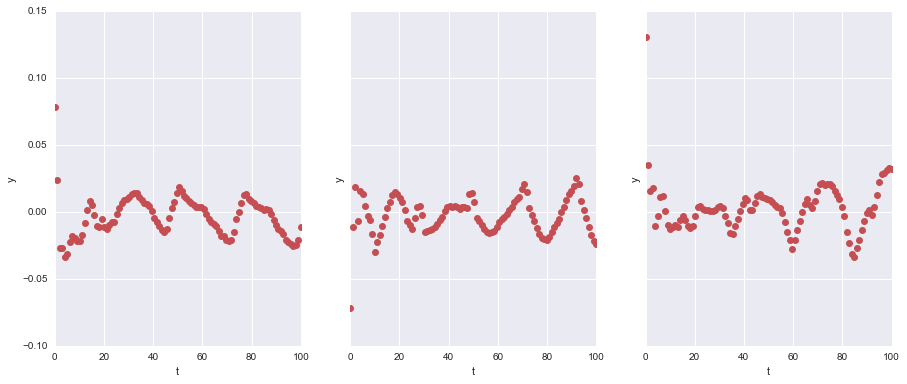

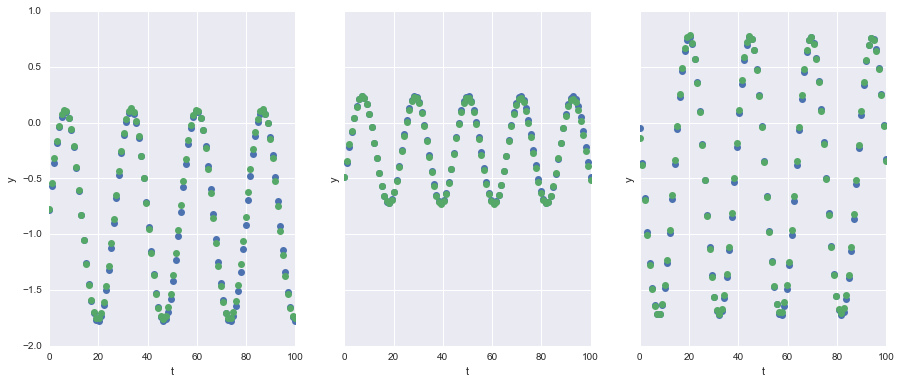

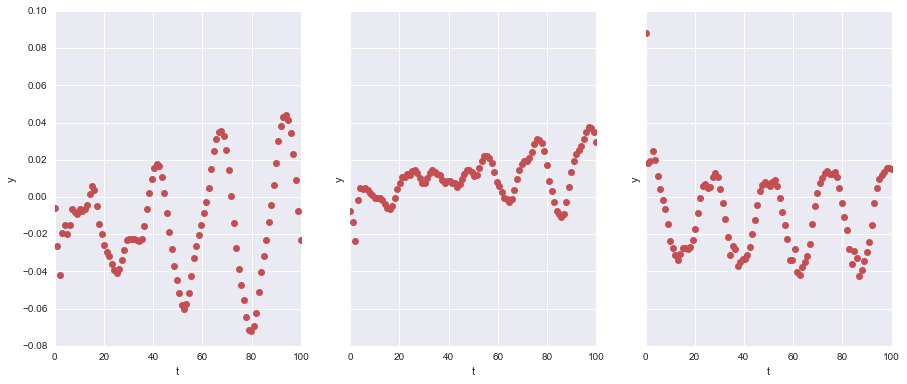

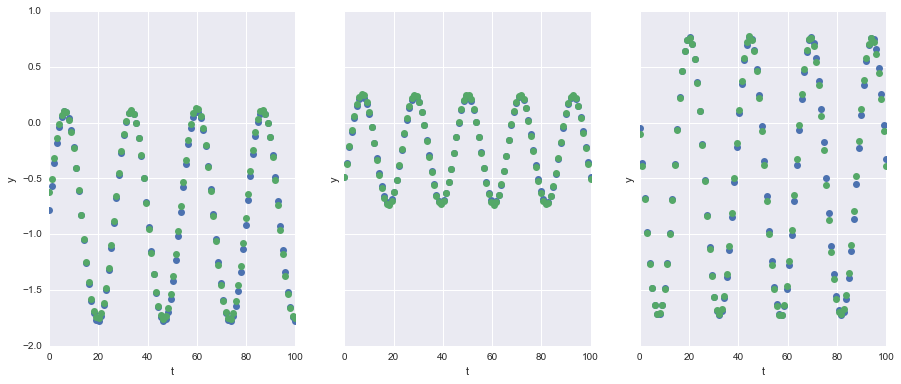

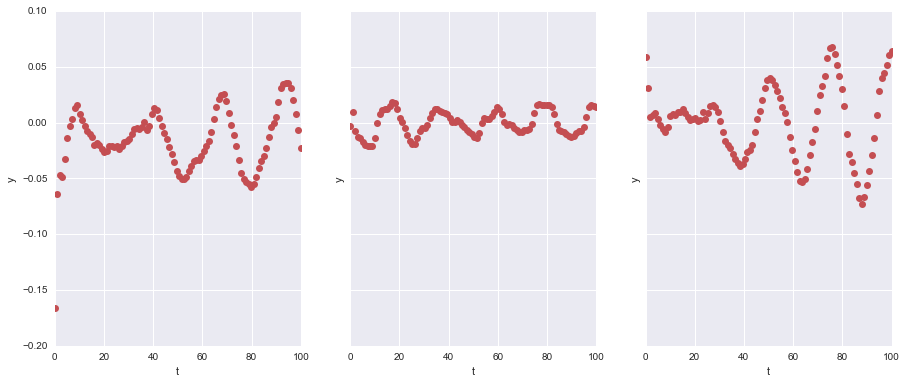

In [2]:
for num_layers in [1, 2, 3]:
    %run period_inverse.py 64 $num_layers 0.25 --model_type gru

    predict_train = model.predict(Y[train])
    predict_test = model.predict(Y[test])

    fig, ax = plt.subplots(1, 3, sharey=True)
    for j in range(3):
    #    i = np.where(y == j)[0][0]
        i = j
        ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[train[i]], 'o')
        ax.ravel()[j].plot(np.linspace(0, n_max, n_max), predict_train[i], 'o')
    #    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
        ax.ravel()[j].set(xlabel="t", ylabel="y")
    print(Y[0:3, :])

    fig, ax = plt.subplots(1, 3, sharey=True)
    for j in range(3):
    #    i = np.where(y == j)[0][0]
        i = j
        ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[train[i]] - predict_train[i], 'o', color=sns.color_palette()[2])
    #    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
        ax.ravel()[j].set(xlabel="t", ylabel="y")
    print(np.mean((X[train[i]] - predict_train[i]) ** 2))